Use the EO Browser (https://apps.sentinel-hub.com/eo-browser/) to find an image to process.
Note the Tile ID (e.g., 11SQS) and the date of acquisition. If you cannot find an image that covers the the entire tile frame, record the dates for two observations (of the same tile) that were acquired on similar dates with minimal cloud cover. Keep in mind the effect of the changing seasons on your image data and think how you might minimize any additional extra 'noise'. For example, since I am interested in the exposed geology, my criteria includes only selecting scenes that occur in summer months (05-08). 
I have additionally restricted my search to include only images more recent than December 6th 2016 -  the date when the archival product format was changed (see: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention).

My goal is to have complete data for Tile 11SQS. 
Looking at all images with 0% cloud coverage in the region of interest (here: https://apps.sentinel-hub.com/eo-browser/?lat=33.02989&lng=-114.56340&zoom=14), it is evident that we will need to merge two images to have complete data for tile 11SQS.

Now, we need to get the product information for these observations that will allow us to download the data into the .SAFE format (required for Sen2Cor L1C to L2A processing). Install the SentineHub python module (https://sentinelhub-py.readthedocs.io/en/latest/install.html) and create an account (https://services.sentinel-hub.com/oauth/subscription).

Next, enter the Tile ID "11SQS" and paste the date into the function below: 

In [3]:
from sentinelhub import AwsTile

product_ids = set()
product_ids.add(AwsTile(tile_name='11SQS', time='2018-05-26', aws_index='0').get_product_id())
product_ids.add(AwsTile(tile_name='11SQS', time='2018-05-28', aws_index='0').get_product_id())


In [4]:
product_ids

{'S2A_MSIL1C_20180526T181921_N0206_R127_T11SQS_20180526T233525',
 'S2B_MSIL1C_20180528T180919_N0206_R084_T11SQS_20180528T214408'}

Good. Now we are ready to download the imagery in ESA's SAFE format so that we can process the data to L2A.
Since the information we are interested in is located at the surface. Atmospheric correction (namely, removing the effects of 300 miles of atmosphere between the sensor and the surface, and radiometric corrections for elevation/terrain (e.g., shadows)). See: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a

In [13]:
from sentinelhub import AwsProductRequest
data_folder = './rawdata'
n, total = 0, len(product_ids)

for product in product_ids:
    product_request = AwsProductRequest(product_id=product, data_folder=data_folder, safe_format=True)
    product_request.save_data()
    pid = product.split('_')[-2][1:]
    n += 1
    print('|' + pid, sep='', end=': {}% | '.format(round(n/total * 100)), flush=True)

|11SQS: 50% | |11SQS: 100% | 

To run the above command you must have AWS configured via AWS-CLI because Sentinel-2 Data is set to Requester-Pays.

After the above command completes, make sure your data is where you think.

In [16]:
!ls './rawdata'

S2A_MSIL1C_20180526T181921_N0206_R127_T11SQS_20180526T233525.SAFE
S2B_MSIL1C_20180528T180919_N0206_R084_T11SQS_20180528T214408.SAFE


Now you need to Install and configure ESA's L1C to L2A processing tool, Sen2Cor (http://step.esa.int/main/third-party-plugins-2/sen2cor/). I used a T3.2xlarge EC2 instance with Ubuntu installed, over-budget EBS storage on your machine (Roughly 5 GB cushion per image you wish to process). I struggled to get Sen2Cor installed and operational, it took multiple days to get Sen2Cor functional. Despite following the installation instructions ver batim and troubleshooting like mad, I only managed to get the software running on one machine and literally couldn't reproduce a successful install from scratch. The managed to get Sen2Cor running on multiple machines was to image the machine I managed to get it working on and deploy the image out to other machines. So I've prepared an AMI with Sen2Cor and all dependencies installed ready to go for image processing. Plan for ~30-1hr of processing time per image (parallelized on a T3.2xlarge) depending on how many image resolutions you want to process at {10, 20, or 60} or All (default)).

Create a python file called helper.py and paste in the code below.

Sen2Cor installation appends a python2 environment to bash, so use python2 syntax.

In [12]:
!pwd

/home/ubuntu/capstone-work/rawdata


Now execute the helper function to begin the processing.

In [12]:
import os
owd = os.getcwd()
os.chdir('./rawdata')
cmd = 'python helper.py'
#os.system(cmd)
os.chdir(owd)

In [18]:
import glob
fd = dict()
fd['11SQS'] = glob.glob('./rawdata/**L2A_**.SAFE')

In [27]:
import sys

for k, v in fd.items():
    files = []
    cmd = 'mkdir -p {}'.format(k)
    os.system(cmd)
    for band_spec in ['B02_20m', 'B04_20m', 'B12_20m']:
        for file in v:
            path = './{}/GRANULE/**/IMG_DATA/R20m/*{}.jp2'.format(file, band_spec)
            f = glob.glob(path, recursive=True)
            files.extend(f)
            
        mergename = '{}/'.format(k) + '{}'.format(k) + '_{}_MERGE.tif'.format(band_spec)
        param = ['', '-n', '0', '-o', mergename]
        param.extend(files)
        sys.path.append('/home/ubuntu/anaconda3/bin/')
        import gdal_merge as gm
        gm.main(param)
        print('Completed:', mergename)

Completed: 11SQS/11SQS_B02_20m_MERGE.tif
Completed: 11SQS/11SQS_B04_20m_MERGE.tif
Completed: 11SQS/11SQS_B12_20m_MERGE.tif


In [28]:
folders = glob.glob('./11SQS/**/', recursive=True)
tiles = []
tiles = [path[:-1].split('/')[-1] for path in folders]

In [74]:
import rasterio

# This function writes out a 3-band geotiff from 3, 1-band geotiffs.
for tile in tiles:
    files = glob.glob('./{}/*'.format(tile))
    for file in files:
        if 'B02_20m' in file:
            b2path = file
        elif 'B04_20m' in file:
            b4path = file
        elif 'B12_20m' in file:
            b12path = file
            
    # Ingest one band to scrape image metadata
    with rasterio.open(b2path, 'r') as initial:
        meta = initial.meta.copy()
        # Update the image metadata to reflect 3 bands
        meta.update(driver='GTiff', count=3)
    
    # Write out each band to the destination file
    with rasterio.open('./{}/{}_stack_geo.tif'.format(tile, tile), 'w', **meta) as dst:
        for n, band in enumerate([b2path, b4path, b12path], start=1):
            with rasterio.open(band) as src:
                dst.write_band(n, src.read(1))


In [1]:
#src = rasterio.open('./11SQS/11SQS_stack_geo.tif')

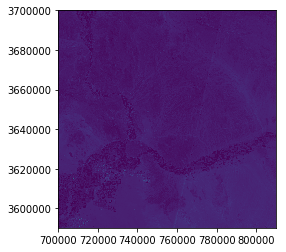

In [92]:
from rasterio.plot import *
show(src)

In [2]:
from geotoolkit import build_class_color_dict

In [3]:
a = build_class_color_dict()

In [4]:
a

{'Q': (0, 'rgb(244,242,230)'),
 'QTb': (1, 'rgb(240,213,240)'),
 'QTv': (2, 'rgb(227,196,240)'),
 'Qr': (3, 'rgb(255,255,186)'),
 'Qy': (4, 'rgb(255,255,227)'),
 'Qo': (5, 'rgb(253,252,155)'),
 'QTs': (6, 'rgb(255,232,186)'),
 'Tvy': (7, 'rgb(255,168,255)'),
 'Tsy': (8, 'rgb(255,232,196)'),
 'Tby': (9, 'rgb(255,186,227)'),
 'Tb': (10, 'rgb(255,158,227)'),
 'Tsv': (11, 'rgb(251,196,123)'),
 'Tsm': (12, 'rgb(226,184,84)'),
 'Tv': (13, 'rgb(253,193,88)'),
 'Tg': (14, 'rgb(251,186,123)'),
 'Ti': (15, 'rgb(253,158,105)'),
 'TXgn': (16, 'rgb(251,154,170)'),
 'Tso': (17, 'rgb(238,215,146)'),
 'TKgm': (18, 'rgb(255,135,145)'),
 'TKg': (19, 'rgb(253,119,101)'),
 'Kv': (20, 'rgb(209,255,135)'),
 'KJo': (21, 'rgb(186,255,158)'),
 'Kmv': (22, 'rgb(232,255,168)'),
 'Ks': (23, 'rgb(179,251,133)'),
 'Jm': (24, 'rgb(120,240,119)'),
 'Yg': (25, 'rgb(202,139,79)'),
 'Jsv': (26, 'rgb(125,255,178)'),
 'Jg': (27, 'rgb(228,95,176)'),
 'J^': (28, 'rgb(178,255,240)'),
 '}|': (29, 'rgb(129,253,128)'),
 'Js': (

In [100]:
import matplotlib.pyplot as plt
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)
b1, b2, b3

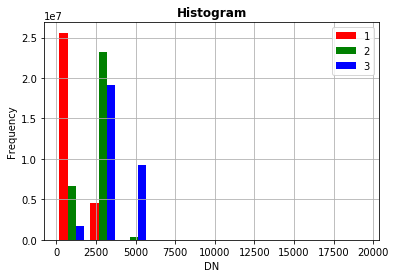

In [91]:
show_hist(src)

In [101]:
!pwd

/home/ubuntu/capstone-work


In [7]:
import geotoolkit as geotk

In [103]:
rst_path = './11SQS/11SQS_stack_geo.tif'
azgeo_path = './geologic-map-of-arizona/data/MapUnitPolys.geojson'
path_to_desc = './geologic-map-of-arizona/data/DescriptionOfMapUnits.csv'

In [104]:
# Find all vector layers that intersecting with the image, rasterize it.
label_array = geotk.generate_label_array(rst_path, azgeo_path, path_to_desc)
# Format name of file to write
out_fn = geotk.format_label_fn(rst_path)
# Writes rasterized labels numpy array to GeoTiff
geotk.write_label_image(label_array, rst_path, out_fn)

In [108]:
# Check to see that labels.tif file is there.
!ls 11SQS

11SQS_B02_20m_MERGE.tif  11SQS_B12_20m_MERGE.tif  11SQS_stack_geo.tif
11SQS_B04_20m_MERGE.tif  11SQS_labels.tif


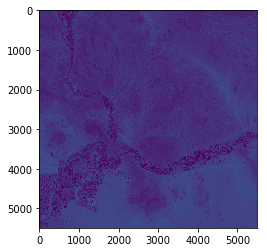

In [131]:
lblpth = './11SQS/11SQS_labels.tif'
imgpth = './11SQS/11SQS_stack_geo.tif'

# Check out band 2 of image
show(rasterio.open(imgpth).read(2))

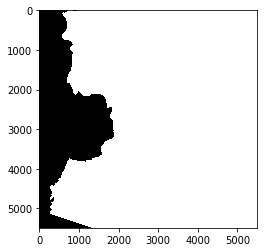

In [132]:
srclbl = rasterio.open(lblpth)
msk = srclbl.read_masks()
show(msk) 

In [137]:
geotk.mask_raster(imgpth, lblpth)

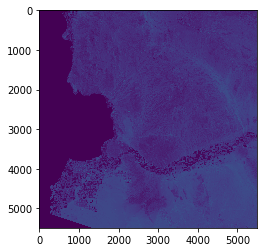

In [138]:
rstpth = imgpth.replace('stack_geo', 'raster' )
show(rasterio.open(rstpth).read(2))

In [ ]:
!ls 11SQS

In [2]:
path_to_desc = '../geologic-map-of-arizona/data/MapUnitPolys.geojson'
azgeo_path = '../geologic-map-of-arizona/data/MapUnitPolys.geojson'

In [1]:
import pandas as pd
import geopandas as gpd
from geotoolkit import *

In [ ]:
def write_label_image(label_array, path_to_rasterfile, fn_write):
    '''
    Write out the numpy array with the raster's geoinformation to a file.
    '''
    with rasterio.open(path_to_rasterfile, 'r') as src:
        meta = src.meta.copy()
        meta.update(dtype=str(meta['dtype']))
        w, h = meta['width'], meta['height']
        crs, trs = meta['crs'], meta['transform']
        
    r, g, b = np.dsplit(label_array, 3)
    r = r.reshape(w, h)
    g = g.reshape(w, h)
    b = b.reshape(w, h)
    
    with rasterio.open(fn_write, 'w', **DefaultGTiffProfile(count=3, width=w, height=h), crs=crs, transform=trs) as dst:
        for k, arr in [(1, r), (2, g), (3, b)]:
            dst.write(arr, indexes=k)

    return

In [241]:
def format_out_fn(path_to_file, lbl='tiled_raster'):
    '''
    Given a filepath, return an 'out' file to write.
    '''
    if '/' in path_to_file:
        fn = path_to_file.split('/')[-1]
        fn_length = len(fn)
        path = path_to_file.replace(fn, '')
    else:
        fn = path_to_file
        fn_length = len(path_to_file)
        path = ''
        
    tile = fn.split('_')[0]
    label_fn = tile + '_' + lbl + '.tif'
    
    return path + label_fn

In [209]:
def find_divisors(dimension, min_size=0, max_size=900):
    ''' Returns dict with possible number of tiles and tile size in pixels.
    '''
    terms = dict()
    for i in range(1, max_size):
        if dimension % i == 0:
            div = round(dimension / i)
            if (div <= min_size) or (div >= max_size):
                continue
            if div**2 in terms.keys():
                break
            terms[i**2] = div
            
    return terms

In [225]:
divs = find_divisors(w)
divs

{81: 610, 100: 549, 225: 366, 324: 305, 900: 183, 2025: 122, 3721: 90}

In [185]:
divs = find_divisors(w)
num_tiles, px_size = (min(divs.keys()), divs.pop(min(divs.keys()))) # num_tiles, size in pixels

In [25]:
def tile_geotiff(file, bx=256, by=256, compress=None):
    if blockx % 16 != 0 or blocky % 16 != 0:
        print('Bad block sizes. Pick multiples of 16.')
        return 
        
    with rasterio.open(file, 'r') as src:
        prof = src.profile
        n = prof['count']
        b1, b2, b3 = (src.read(band) for band in range(1, n+1))
        
        prof['interleave'] = 'band'
        prof['tiled'] = True
        prof['blockxsize'] = 256
        prof['blockysize'] = 256
        prof['compress'] = None

        fn_write = format_out_fn(file, 'tiled_raster')
        with rasterio.open(fn_write, 'w', **prof) as dst:
            for k, arr in [(1, b1), (2, b2), (3, b3)]:
                dst.write(arr, indexes=k)
                
    return

In [294]:
files = glob.glob('/Volumes/tjds/geostacks/rasters/**')
for file in files:
    tile_geotiff(file)

In [270]:
src_path = '/Volumes/tjds/geostacks/trash/SYD_raster.tif'

with rasterio.open(src_path, 'r') as src:
    meta = src.meta.copy()
    profile = src.profile
    fids = ['width', 'height', 'crs', 'transform', 'count']
    w, h, crs, trs, nband = (meta[fid] for fid in fids)
    
    b1, b2, b3 = (src.read(band) for band in range(1, nband+1))
    
    dtype = b1.dtype

    fn_write = format_out_fn(src_path)
    with rasterio.open('SYD_tiled_raster.tif', 'w', **DefaultGTiffProfile(count=nband, dtype=dtype, width=w, height=h, compress=None), crs=crs.data, transform=trs) as dst:
        for k, arr in [(1, b1), (2, b2), (3, b3)]:
            dst.write(arr, indexes=k)

In [15]:
import boto3

def get_tilenames():
    s3 = boto3.client('s3')
    lab = s3.list_objects_v2(Bucket='tjds', Prefix='geostacks/labels')['Contents']
    tile_ids = [i['Key'].split('/')[-1][:3] for i in lab if '.tif' in i['Key']]
    
    return tile_ids


def tile_train_test_split(ids=list, test=[], count=3):
    tiles = np.array(ids)
    if val_ids:
        train = list(set(tiles) - set(test))
    else:
        test = np.random.choice(tiles, a=count, replace=False)
        train = list(set(tiles) - set(test))
    return train, test

0.28041724731376405

In [9]:
tiles = get_tilenames()

In [7]:
s3 = boto3.client('s3')
rst = s3.list_objects_v2(Bucket='tjds', Prefix='geostacks/rasters')['Contents']
imgs = [i['Key'] for i in rst if '.tif' in i['Key']]

In [11]:
val_ids = ['SVE', 'SQT', 'SXD']

In [12]:
train_ids = list(set(tiles) - set(val_ids))

In [13]:
train_ids

['SWD',
 'SXF',
 'SUD',
 'SWB',
 'STB',
 'SUA',
 'SUF',
 'SVD',
 'SVF',
 'STA',
 'SUC',
 'SXE',
 'SWC',
 'SWE',
 'SQA',
 'SQR',
 'STF',
 'RVV',
 'SVC',
 'SWF',
 'SXC',
 'SXA',
 'SXB',
 'SVA',
 'SUE',
 'STD',
 'RXV',
 'SWA',
 'STE',
 'SUB',
 'RWV',
 'SQV',
 'STC',
 'SQU',
 'SQS',
 'SVB']

'SEMANTIC_SEGMENTATION'

In [1]:
import pandas as pd
df = pd.read_clipboard()

In [2]:
t = df.iloc[:, 6].apply(lambda x: x[1:]).astype(float).mean()
b = df.iloc[:, 2].apply(lambda x: x[:-1]).astype(int).max()
print('Approximately', round(((1.5e5 - b) * t ) / (60**2), 2), 'hours remaining of', round(((1.5e5) * t ) / (60**2), 2), 'hours total.')

Approximately 6.71 hours remaining of 23.87 hours total.
